In [1]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as compare_ssim
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [2]:
video_path = 'videos/Chrono Cross Cena Seguinte.mp4'
scale = 4

In [3]:
def start_dnn_superres(scale):
    sr = cv.dnn_superres.DnnSuperResImpl_create()
    path = "models/ESPCN_x{}.pb".format(str(scale))
    sr.readModel(path)
    sr.setModel("espcn",scale)
    return sr

def plot_results(img, result, resized):
    plt.figure(figsize = (20, 6), dpi = 200)
    # Original image
    plt.subplot(1,3,1), plt.imshow(img[:,:,::-1])
    # SR upscaled
    plt.subplot(1,3,2), plt.imshow(result[:,:,::-1])
    # OpenCV upscaled
    plt.subplot(1,3,3), plt.imshow(resized[:,:,::-1])
    plt.show()

def getQualityValues(orig, upsampled):
    psnr = cv.PSNR(upsampled, orig)
    # q = quality::QualitySSIM::compute(upsampled, orig)
    # q = cv.QualitySSIM(upsampled, orig)
    # ssim = np.mean((q[0]), q[1], q[2])[0]
    # return (psnr, ssim)
    
    ssim = compare_ssim(upsampled, orig, multichannel=True)
    return (psnr, ssim)

sr = start_dnn_superres(scale)

video_h, video_w = 600, 800
width = video_w - (video_w % scale)
height = video_h - (video_h % scale)

In [13]:
# Inspired in keras tutorial: https://keras.io/examples/vision/super_resolution_sub_pixel/
def add_zoom(img, ax):
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False),plt.xticks(visible=False)
    return axins

def keras_plot_results(img1, img2):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 10), dpi = 200)
    ax1.imshow(img1[::-1], origin="lower"), ax1.set_title('Original')
    ax2.imshow(img2[::-1], origin="lower"), ax2.set_title('High Resolution')

    axins_1 = add_zoom(img1, ax1)
    axins_2 = add_zoom(img2, ax2)

    # Make the line.
    mark_inset(ax1, axins_1, loc1=1, loc2=3, fc="none", ec="blue")
    mark_inset(ax2, axins_2, loc1=1, loc2=3, fc="none", ec="blue")
    # plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()

(600, 800, 3) (600, 800, 3) (150, 200, 3) (600, 800, 3)
PSNR: 34.47885891709648, SSIM: 0.9114281814430378


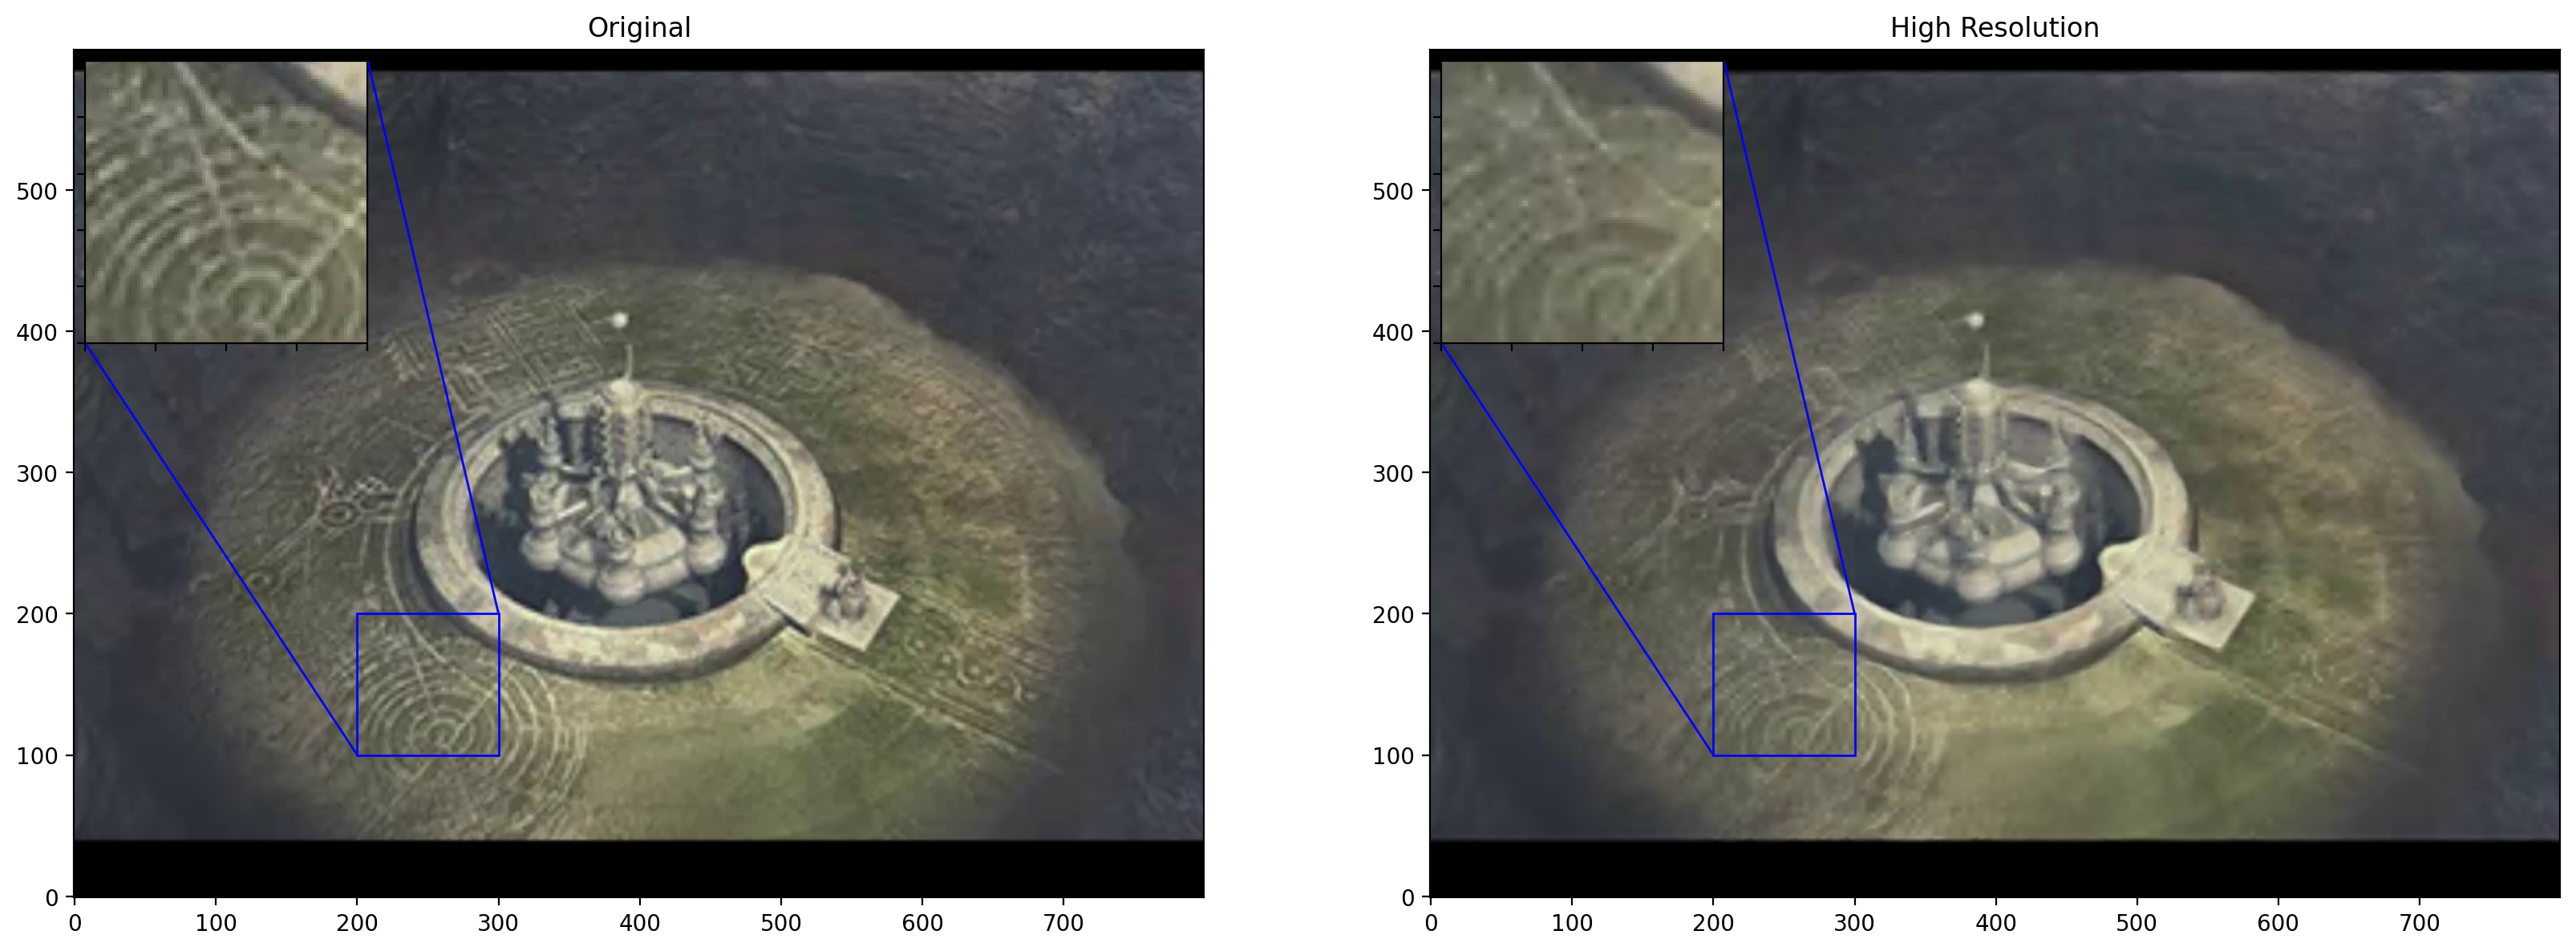

In [14]:
capture = cv.VideoCapture(video_path)
if not capture.isOpened():
    print("Cannot open video")
    exit()

while capture.isOpened():
    ret, frame = capture.read()
    if not ret:
        print("Can't read frame")
        break
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB) # cv.COLOR_BGR2GRAY

    cropped = frame[:height, :width]
    # Downscale the image for benchmarking
    downscaled = cv.resize(cropped, dsize=None, fx=1.0 / scale, fy=1.0 / scale);
    # downscaled = cv.resize(cropped, dsize=None, fx=1.0/4,fy=1.0/4)
    img_new = sr.upsample(downscaled)

    print(frame.shape, cropped.shape, downscaled.shape, img_new.shape)
    quality = getQualityValues(cropped, img_new)

    print("PSNR: {}, SSIM: {}".format(quality[0],quality[1]))
    # plot_results(frame, img_new, downscaled)
    keras_plot_results(frame, img_new)

    break
capture.release()
cv.destroyAllWindows()